In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
cd ../..

/


In [ ]:
cd gdrive/My\ Drive

/gdrive/My Drive


In [ ]:
cd Many Body

/gdrive/My Drive/Many Body


In [ ]:
!apt-get install libmpfr-dev

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  libgmp-dev libgmpxx4ldbl
Suggested packages:
  gmp-doc libgmp10-doc libmpfr-doc
The following NEW packages will be installed:
  libgmp-dev libgmpxx4ldbl libmpfr-dev
0 upgraded, 3 newly installed, 0 to remove and 37 not upgraded.
Need to get 575 kB of archives.
After this operation, 2,899 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/main amd64 libgmpxx4ldbl amd64 2:6.1.2+dfsg-2 [8,964 B]
Get:2 http://archive.ubuntu.com/ubuntu bionic/main amd64 libgmp-dev amd64 2:6.1.2+dfsg-2 [316 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/main amd64 libmpfr-dev amd64 4.0.1-1 [249 kB]
Fetched 575 kB in 1s (756 kB/s)
Selecting previously unselected package libgmpxx4ldbl:amd64.
(Reading database ... 155229 files and directories currently installed.)
Preparing to unpack .../libgmpxx4ldbl_2%3a6.1.2+dfsg-2_amd64

In [ ]:
!pip install bigfloat

     |████████████████████████████████| 258 kB 5.1 MB/s 
  Created wheel for bigfloat: filename=bigfloat-0.4.0-cp37-cp37m-linux_x86_64.whl size=578895 sha256=47af88f6f6a64e970cc75c49ca0f27b0dffd013ef5fd5f3f9f1bb75313566d4c
  Stored in directory: /root/.cache/pip/wheels/0e/1b/9a/c31123a367a35255512d099b6c132be84d69f581bd9e97ebf1
Successfully built bigfloat


In [ ]:
from bigfloat import *

In [ ]:
import numpy as np
import matplotlib.pylab as plt
import sympy as sym
from mpmath import *
from sympy import N

In [ ]:
mp.dps = 82  # set precision
print(mp)

Mpmath settings:
  mp.prec = 276               [default: 53]
  mp.dps = 82                 [default: 15]
  mp.trap_complex = False     [default: False]


In [ ]:
def h(y):
  """ Mobius transformation h(z) = (z - i)/(z + i) """
  return (mpc(y) - mpc(0,1))/(mpc(y) + mpc(0,1))

In [ ]:
def Pick_matrix(Y, Lambda):

  """ This function takes {\y_i} and {\theta(y_i)} arrays as input and forms the Pick matrix """

  n = len(Y)
  Pick = np.zeros((n,n))
  for i in range(n):
    for j in range(n):

      Pick[i, j] = (1 - Y[i] * np.conjugate(Y[j])) / (1 - h(Lambda[i]) * np.conjugate(h(Lambda[j])))

  return Pick

# Schur Algorithm

In [ ]:
def Schur_Algorithm(y_array, lambda_array, k):

  z = sym.symbols('z', complex = True)

  DPS = mp.dps
  
  a1 = (z - mpc(y_array[0])) / (z - conj(y_array[0]))
  b1 = mpc(lambda_array[0])
  c1 = conj(lambda_array[0]) * (z - mpc(y_array[0])) / (z - conj(y_array[0]))
  d1 = mpc(1)

  theta_1 = (-d1 * lambda_array[1] + b1) / ( mpc(c1.subs({z:y_array[1]})) * lambda_array[1] - mpc(a1.subs({z:y_array[1]})) )
  conj_theta_1 = conj(theta_1)

  for i in range(1, k):

    y2 = mpc(y_array[i])
    lambda2 = mpc(lambda_array[i])

    a2 = (a1 + conj_theta_1 * b1) * (z - y2)/(z - conj(y2))
    b2 = a1 * theta_1 + b1
    c2 = (c1 + conj_theta_1 * d1) * (z - y2)/(z - conj(y2))
    d2 = c1 * theta_1 + d1
    
    a1 = a2
    b1 = b2
    c1 = c2
    d1 = d2

    if i < (k-1) :
      y2 = mpc(y_array[i+1])
      lambda2 = mpc(lambda_array[i+1])

      theta_1 = mpc(N((-N(d1.subs({z:y2}), DPS) * lambda2 + N(b1.subs({z:y2}), DPS) ) / ( N(c1.subs({z:y2}), DPS) * lambda2 - N(a1.subs({z:y2}), DPS) ), DPS) )
      conj_theta_1 = conj(theta_1)

  
  theta_M = mpc(0)

  theta_z = (a2 * theta_M + b2) / (c2 * theta_M + d2)

  return mpc(0,1) * (mpc(1,0) + theta_z) / (mpc(1,0) - theta_z)

## Initializing the system -- Exact solution

In [ ]:
m = 20  # number of matsubara frequencies: m/2 + 1
N_L = 21  # lattice size
k = 2* np.pi / N_L * np.arange(-N_L/2 + 1, N_L/2)  # Brillouin zone 
t = 1
L = 800 # Number of omega points 
Beta = 10
Eta = 0.01
mu = 0

In [ ]:
def PI_func(q, qn, k, t, Beta, mu, N_L):
  
  E_k = -2*t * np.cos(k)
  E_kq = -2*t * np.cos(k + q)
  nF_k = 1 / (1 + np.exp(Beta * (E_k - mu)))
  nF_kq = 1 / (1 + np.exp(Beta * (E_kq - mu)))

  PI_q = 1/N_L * sum( (nF_k - nF_kq) / (qn + E_k - E_kq) )

  return PI_q

In [ ]:
omega = np.linspace(0, 5, L)

PI_EXACT = np.zeros(L, dtype=np.complex_)

for i in range(L):
    
    PI_EXACT[i] = (PI_func(np.pi, omega[i] + 1j * Eta, k, t, Beta, mu, N_L))
    


A_array = -1/np.pi * PI_EXACT.imag   # spectral density

### Generating $iq_n$ and $\Pi(\pi, iq_n)$

In [ ]:
qn = 1j * np.pi/Beta * np.arange(m, -1 , -2)
n_s = len(qn)

Gamma_z = np.zeros(n_s, dtype=np.complex_)

for i in range(n_s):
    
  Gamma_z[i] = PI_func(np.pi, qn[i], k, t, Beta, mu, N_L)
  

In [ ]:
n_s # number of matsubara points

11

In [ ]:
Lambda_A = np.zeros(n_s, dtype=np.complex_)
for i in range(n_s):
  Lambda_A[i] = h(Gamma_z[i])

In [ ]:
NG = Schur_Algorithm(qn, Lambda_A, n_s)

In [ ]:
z = sym.symbols('z', complex = True)
f = sym.lambdify(z, NG)

In [ ]:
SPd = f(omega + 1j * Eta)

In [ ]:
Nev = -1/np.pi * SPd.imag

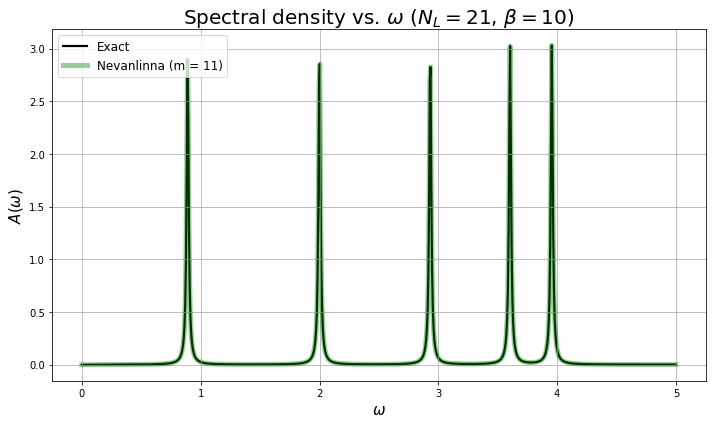

In [ ]:
plt.rcParams["figure.figsize"] = (10,6)

# fig, (ax1, ax2, ax3) = plt.subplots(3,1, figsize = (9,17))

Real_PI1 = plt.plot(omega, A_array, color = 'black', linewidth = 2.2, linestyle= '-', label = 'Exact', zorder = 1)


NEV_PI1 = plt.plot(omega, Nev, color = 'green', linestyle= '-' , label = 'Nevanlinna (m = 11)',linewidth = 5, alpha = 0.4)


plt.xlabel('$\omega$', fontsize = 15)
plt.ylabel('$A(\omega)$', fontsize = 15)

plt.title('Spectral density vs. $\omega$ ($N_L = 21$, $\\beta = 10$)', fontsize = 20)
plt.legend(fontsize = 12, loc = 2)

plt.grid('on')

plt.tight_layout()
plt.savefig('Nev_21.png')

### plot for different number of Matsubara points

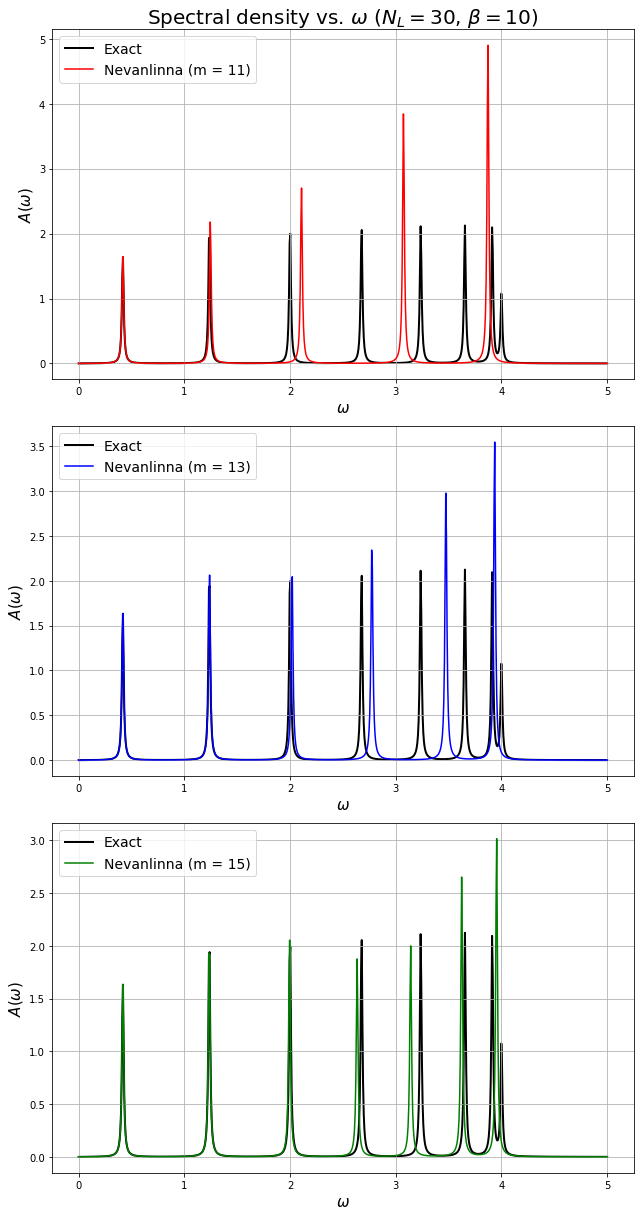

In [ ]:
# plt.rcParams["figure.figsize"] = (10,7)

fig, (ax1, ax2, ax3) = plt.subplots(3,1, figsize = (9,17))

Real_PI1 = ax1.plot(omega, A_array, color = 'black', linewidth = 2, linestyle= '-', label = 'Exact', zorder = 1)
Real_PI2 = ax2.plot(omega, A_array, color = 'black', linewidth = 2, linestyle= '-', label = 'Exact', zorder = 1)
Real_PI3 = ax3.plot(omega, A_array, color = 'black', linewidth = 2, linestyle= '-', label = 'Exact', zorder = 1)

NEV_PI1 = ax1.plot(omega, Nev_11, color = 'red', label = 'Nevanlinna (m = 11)', alpha = 1)
NEV_PI2 = ax2.plot(omega, Nev_13, color = 'blue', label = 'Nevanlinna (m = 13)', alpha = 1)
NEV_PI3 = ax3.plot(omega, Nev_15, color = 'green', label = 'Nevanlinna (m = 15)', alpha = 1)

ax1.set_xlabel('$\omega$', fontsize = 15)
ax1.set_ylabel('$A(\omega)$', fontsize = 15)
ax2.set_xlabel('$\omega$', fontsize = 15)
ax2.set_ylabel('$A(\omega)$', fontsize = 15)
ax3.set_xlabel('$\omega$', fontsize = 15)
ax3.set_ylabel('$A(\omega)$', fontsize = 15)
ax1.set_title('Spectral density vs. $\omega$ ($N_L = 30$, $\\beta = 10$)', fontsize = 20)
ax1.legend(fontsize = 14)
ax2.legend(fontsize = 14)
ax3.legend(fontsize = 14)
ax1.grid('on')
ax2.grid('on')
ax3.grid('on')
plt.tight_layout()
# plt.savefig('Nev.png')